Let $Y^*(t,\tau)$ be the number of people infected in interval $[t,t+1)$ by people who where infected in time interval $[t-\tau,t-\tau+1)$. 

We use the following recursion for $Y^*(t,\tau)$:
$$Y^*(t,\tau) = S(t)/N \sum_{\tau'=\tau}^K Y^*(t-\tau,\tau'-\tau) \int_{\tau'}^{\tau'+1}\int_{\tau}^{\min(\hat{\tau}',\tau+1)}f(\hat{\tau}',\hat{\tau})d\hat{\tau}d\hat{\tau}'$$
Where $$f(\tau',\hat{\tau})=\beta(\hat{\tau})(1-\epsilon_Is(\hat{\tau}))\left(1-\epsilon_T + \epsilon_T\frac{1-s(\tau')}{1-s(\tau'-\hat{\tau}))}\right)$$
Here $s(\tau)$ is the incubation period which we assume to be lognormal distributed with meanlog 1.644 and sdlog 0.363. Let $K$ be the number of days an infected patient can spread the virus, we assume $K=13$.  $\beta(\tau)=R_0 w(\tau)$. We approximate $R_0=2$ and the generation time $w$ is weibull distributed with shape parameter 2.826027 and scale parameter 5.665302.

Note: In the sum, only the first term ($\tau'=\tau$) uses the min-statement, for all other terms it is just $\tau+1$ in the second integral.

We use the following model to keep track of the number of suspectible ($S$), $k$-days infected ($I_k$), hospitalised ($H$), deceased ($D$) and recovered ($R$) patients. 
\begin{align}
S(t+1) &= S(t) - \sum_{k=1}^K Y^*(t,k)\\
I_1(t+1) &= \sum_{k=1}^K Y^*(t,k)\\
I_k(t+1) &= I_{k-1}(t) \qquad \text{for } k=2,3,..,K\\
H(t+1) &= H(t)+\gamma_{I,H} I_K(t) - (\gamma_{H,D}+\gamma_{H,R})H(t)\\
R(t+1) &= R(t)+ (1-\gamma_{I,H})I_K(t)+\gamma_{H,R}H(t)\\
D(t+1) &= D(t) + \gamma_{H,D} H(t)
\end{align}

Let $$g(\tau,\tau)=\int_{\tau}^{\tau+1}\int_{\tau}^{\tau'}\beta(\hat{\tau})(1-\epsilon_Is(\hat{\tau}))\left(1-\epsilon_T + \epsilon_T\frac{1-s(\tau')}{1-s(\tau'-\hat{\tau}))}\right)d\hat{\tau}d\tau',$$
and for $\tau'> \tau$  
$$g(\tau,\tau')=\int_{\tau'}^{\tau'+1}\int_{\tau}^{\tau+1}\beta(\hat{\tau})(1-\epsilon_Is(\hat{\tau}))\left(1-\epsilon_T + \epsilon_T\frac{1-s(\hat{\tau}')}{1-s(\hat{\tau}'-\hat{\tau}))}\right)d\hat{\tau}d\hat{\tau'}.$$
Then $$Y^*(t,\tau)=S(t)/N \sum_{\tau'=\tau}^KY^*(t-\tau,\tau'-\tau)g(\tau,\tau').$$
We can see $g(\tau,\tau')$ as the infection rate of someone infected $\tau$ days ago, that was infected by someone who was infected $\tau'$ days ago.

For the initial values of $Y*$ we use the following. We assume that there is no quarantine and no tracing for $12\leq t\leq0$. Then we say $Y^*(t,\tau) = \int_{K-\tau}^{K-\tau+1} \beta(\hat{\tau})d\hat{\tau}I_{-t}(0)$. As $I_{-t}(0)$ is the number of new infected people at time $t$, and we estimate the fraction of infected people at time $t$ that is infected $t-\tau$ days ago by  $\int_{K-\tau}^{K-\tau+1} \beta(\tau')d\tau'$. (This would be a reasonoable estiamtion if the number of infected people is constant for $t\leq0$ which is obviously not the case.)

We start by setting initial values and parameter estimates.

In [1]:
from scipy.stats import weibull_min
from scipy.stats import lognorm
import cmath
import math 
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import dblquad
from scipy.integrate import quad

In [2]:
# The number of deceased patients from 10-04 back to 28-03 is multiplied by 100 
# to estimate the number of infected patients from 28-03 back to 17-03
# The number of recovered patients is calculated by summing up the number of deceased
# patients up to 17-03 and multiply by 100 * 0.99
N = 17000000
K=13
Ikt = [ [9800] , [9000],[12200],[13400],[14500],[14200],[14900],[15100],[15900],[15200],[15800],[14700],[11700]]
R = [ N*0.03 ] #About 3 percent of the people has been infected and is recovered now.
H = [1232] #number of tested corona patients on the IC 10-04
D = [0] #We will look at the number of deceased patients starting the count on zero
Itotal = [sum([Ikt[i][-1] for i in range(K)])]
S = [N - Itotal[0] -R[0]-H[0]-D[0]]

#We will repeat the initialisation step every run, so this is just to get an overview of the values. 


In [3]:
#Define the parameters values of the gammas (\gamma_{H,R} ->gHR) These values come from the science paper.
gIH = 0.026445154
#gHD = 0.001859002 #20 days on IC
#gHR = 0.048140998 

gHD = 0.003718003 #10 days on IC
gHR = 0.096281997

The parameters above are based on a combination of https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf and https://opendata.cbs.nl/statline/?dl=308BE#/CBS/nl/dataset/7461bev/table, but are just estimates. 

In [4]:
K=13 #By the Science paper, someone who is infected will remain infectious for 13 days.

#Set efficacy
epsI = 0
epsT = 0

#Define the generation time distribution
genWeibShape = 2.826027
genWeibScale = 5.665302
R0=2
#BetaTau = [(2*weibull_min(genWeibShape, 0, genWeibScale).pdf(x)) for x in range(K)]

#Define incubation time distribution
incMeanLog = 1.644
incSdLog = 0.363
#incubTau = [(lognorm.cdf(x,incSdLog,0,math.exp(incMeanLog))) for x in range(0,K+1)]

def incub(tau): #get probability that incubation time is lower than tau
    return lognorm.cdf(tau,incSdLog,0,math.exp(incMeanLog))

def gener(tau): #probability density of generation time at tau
    return R0*weibull_min(genWeibShape, 0, genWeibScale).pdf(tau)

def f(ht,htp): #Here we mean ht=\hat{\tau} and htp=\hat{\tau}' (p of prime)
    if (htp >= ht): #This just function f as defined above
        return gener(ht)*(1-epsI*incub(ht))*(1-epsT+epsT*(1-incub(htp))/(1-incub(htp-ht))) 
    else:
        return 0
        
def G(tau,taup): #This is funciton g as defined above, taup= \tau'
    if (taup >= tau):
        return dblquad( lambda ht, htp : f(ht,htp), taup, taup+1, lambda x: tau, lambda x: min(x,tau +1))
    else:
        return [0]
    
#It takes a long time to calculate these, so we store them in a matrix such that we only have to calculate once.
g = [[G(tau,taup)[0] for taup in range(K)] for tau in range(K)]
#So g(\tau,\tau') is what we defined above.


In [5]:
#Set the values for S for t=-12,-11,...,0
Sbefore0 = [S[0]]
for k in range(K-1):
    Sbefore0.append(S[-1]+Ikt[k][0])
Sbefore0.reverse() #Now Sbefore0[0] = S[-12] -> Sbefore0[12]=S[0]

#Formula as stated above:
YttauI = [[Ikt[-t][0]*quad(gener, K-tau, K-tau+1)[0] for tau in range(K)] for t in range(1,K+1)]
#I for initialised, so we do not have to do this every time if we run the code below.

YttauI.append([0]*K) #make an empty row for Y*(0,:)
for tau in range(1,K):
    #sumhelp is what is in the sum given above, summ is the sum itself.
    sumhelp = [ g[tau][tauPr]*YttauI[12-tau][tauPr-tau] for tauPr in range(tau,K)]
    summ = sum(sumhelp)
    YttauI[-1][tau] = S[-1]/N*summ


Above, the initial values for $Y^*(t,\tau)$ are given. We have $Y^*(t,\tau) = Yttau(t+12,\tau)$ for $t>=-12, \tau =0,1,...,12$.

In [6]:
Ikt = None; R=None; H=None; D=None; Itotal=None;S=None;Yttau=None; Yttot=None;

In [7]:
T = 210 #number of days we want to look ahead.


N = 17000000
Ikt = [ [9800] , [9000],[12200],[13400],[14500],[14200],[14900],[15100],[15900],[15200],[15800],[14700],[11700]]
R = [ N*0.03]
H = [1232] #number of tested corona patients on the IC 10-04
D = [0]
Itotal = [sum([Ikt[i][-1] for i in range(K)])]
S = [N - Itotal[0] -R[0]-H[0]-D[0]]

#Yttau = [([(Sbefore0[t]/N*BetaTau[tau]) for tau in range(K)]) for t in range(K)]
Yttau = YttauI.copy()
Yttot = [sum(Yttau[-1])] #This is the total number of new infections at t=1
for t in range(0,T):
    
    for k in range(1,K):
        Ikt[k].append(Ikt[k-1][t]) #update every infection class with the previous day
    
    Ikt[0].append(Yttot[-1]) #new infections 
    S.append(S[-1] - Yttot[-1]) #remove the new infections from S
    Itotal.append(sum([Ikt[i][-1] for i in range(K)])) #Update total number of infections
    
    H.append(H[-1]*(1-gHR-gHD) + gIH*Ikt[K-1][t]) #Update hospitalized patients
    R.append(R[-1]+(1-gIH)*Ikt[K-1][t]+gHR*H[t]) #Update recovered patients
    D.append(D[-1]+gHD*H[t]) #Update deceased patients
    
    
    Yttau.append([0]*K) #make an empty row for Y*(t+12,:)
    for tau in range(1,K):
        #sumhelp is what is in the sum given above, summ is the sum itself.
        sumhelp = [ g[tau][tauPr]*Yttau[12+t-tau][tauPr-tau] for tauPr in range(tau,K)]
        summ = sum(sumhelp)
        Yttau[-1][tau] = S[-1]/N*summ
    #We have beta(0)=0, so there are no infections from patients that are infected on the day itself.
    Yttau[-1][0] = 0 #this is already the case.
    Yttot.append(sum(Yttau[-1]))

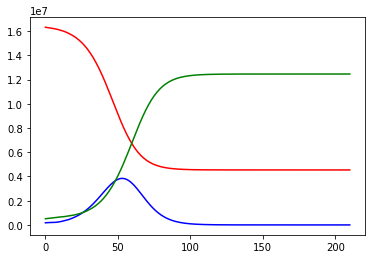

In [11]:
time = range(0,T+1)
plt.figure() #Plot S, I and R in one plot.
plt.plot(time, S, 'r-',time, Itotal,'b-',time, R, 'g-')
plt.show()

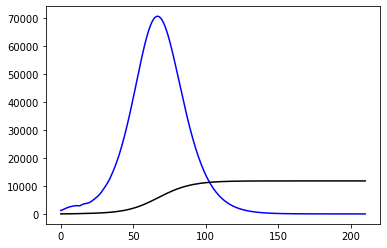

In [12]:
plt.figure() #Plot H and D in one plot
plt.plot(time, H, 'b-', time, D, 'k-')
plt.show()

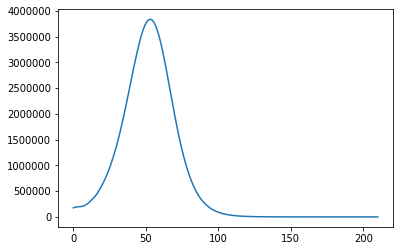

In [13]:
plt.figure()
plt.plot(time,Itotal)
plt.show()